In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import theano
import theano.tensor as tt

/home/ondrej/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(400)

# draw sample from GP (f_true) as the true poisson mean (mu_true) as a function of x_true
l_true = 1.0
eta_true = 1.0
x_true = np.linspace(0, 15, 900)
cov = eta_true**2 * pm.gp.cov.ExpQuad(1, l_true)
f_true = np.random.multivariate_normal(np.zeros(len(x_true)), cov(x_true[:,None]).eval(), 1).flatten()
mu_true = np.exp(f_true)

In [3]:
# make data set with different density of observed data in different places
idx1 = np.random.randint(0,250,250)
x1 = x_true[idx1]
y1 = np.random.poisson(mu_true[idx1])

idx2 = np.random.randint(250,350,10) 
x2 = x_true[idx2]
y2 = np.random.poisson(mu_true[idx2])

idx3 = np.random.randint(500,700,180) 
x3 = x_true[idx3]
y3 = np.random.poisson(mu_true[idx3])

idx4 = np.random.randint(700,900,10) 
x4 = x_true[idx4]
y4 = np.random.poisson(mu_true[idx4])

x = np.concatenate((x1, x2, x3, x4), axis=0)
idx = np.argsort(x)
x = x[idx]
y = np.concatenate((y1, y2, y3, y4), axis=0)[idx]

Number of data points: 450


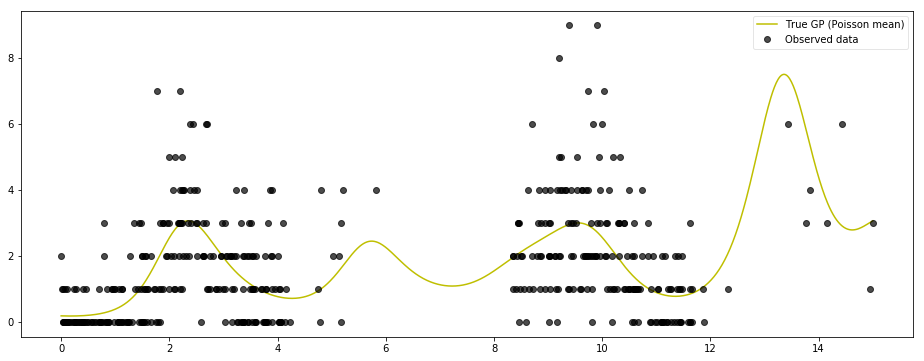

In [4]:
plt.figure(figsize=(16,6))
plt.plot(x_true, mu_true, 'y', label="True GP (Poisson mean)")
plt.plot(x, y, 'ko', label="Observed data", alpha=0.7);
plt.legend();

n = len(x)
X = x[:,None]

print("Number of data points:", n)

In [48]:
Xnew = np.linspace(-1, 20, 100)[:,np.newaxis]

In [99]:
class LatentGPModel(pm.Model):
    '''Unequally spaced and dense Poisson distributed data with a GP prior over the Poisson mean'''
    def __init__(self, approx, Xu=None, name='', model=None):
        if approx is None:
            name += 'full'
        else:
            name += approx
        super(LatentGPModel, self).__init__(name, model)
        l = pm.Gamma("l", alpha=2, beta=1)
        eta = pm.HalfNormal("eta", sd=1)
        cov = eta**2 * pm.gp.cov.ExpQuad(1, l)
        
        if approx is None:
            gp = pm.gp.Latent(cov_func=cov)
            f = gp.prior("f", X=X)
        else:
            gp = pm.gp.LatentSparse(cov_func=cov, approx=approx)
            f = gp.prior("f", X=X, Xu=Xu)
        self.approx = approx
        self.gp = gp
        self.Xu = Xu
        
        y_ = pm.Poisson("y", mu=tt.exp(f), observed=y)
    
    def predict_f(self, trace):
        with LatentGPModel(self.approx, self.Xu) as model_predict:
            fnew = self.gp.conditional("fnew", Xnew=Xnew)
            preds = pm.sample_ppc(trace, vars=[fnew])
        return preds

In [39]:
sample_kw = dict(draws=1000, chains=1)

In [17]:
varnames = ['l', 'eta']
lines = {'l': l_true, 'eta': eta_true}

# Full Latent GP

In [116]:
with LatentGPModel(approx=None) as model_full:
    trace_full = pm.sample(**sample_kw)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [full_f_rotated_, full_eta_log__, full_l_log__]
100%|██████████| 1500/1500 [47:18<00:00,  1.89s/it] 
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [86]:
def show_traceplot(trace, model):
    p = model.name + '_'
    pm.traceplot(trace, 
                 varnames=[p + v for v in varnames],
                 lines={p + k: v for (k ,v) in lines.items()}
                )

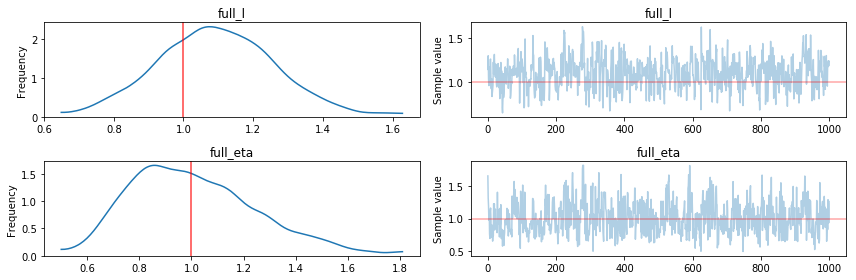

In [117]:
show_traceplot(trace_full, model_full)

In [133]:
def show_ppc(trace, model, newf=True, Xu=None):
    name = model.name + '_f'
    plt.figure(figsize=(16, 6))
    ax = plt.gca()
    if newf:
        pm.gp.util.plot_gp_dist(ax, np.exp(trace[name+'new']), Xnew.flatten(), palette="Blues", label="Conditional GP")
    else:
        pm.gp.util.plot_gp_dist(ax, np.exp(trace[name]), X.flatten(), palette="Blues", label="Posterior GP")
    plt.plot(X.flatten(), y, 'ok', label="Observed data");
    plt.plot(x_true, mu_true, 'y', label="True GP")
    if Xu is not None:
        plt.plot(Xu.flatten(), -1*np.ones(Xu.shape[0]), "bx", label="inducing point locations");
    plt.legend()
    plt.title(name + ' GP model')

In [119]:
fnew_full = model_full.predict_f(trace_full)

100%|██████████| 1000/1000 [00:25<00:00, 38.98it/s]


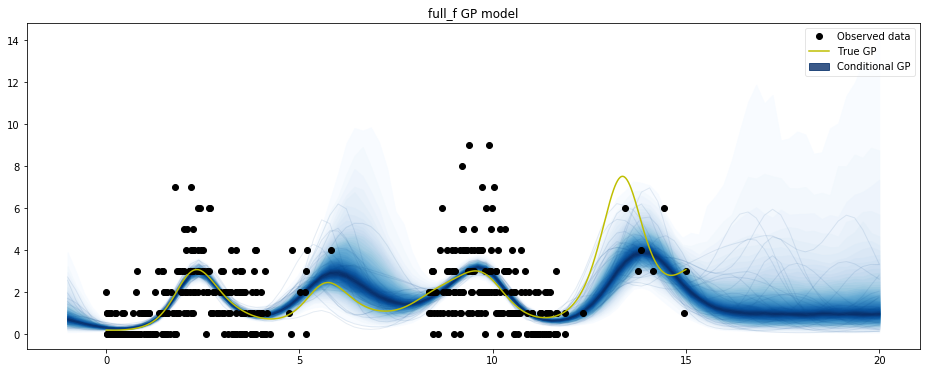

In [137]:
show_ppc(fnew_full, model_full)

# Sparse Latent GP

In [30]:
Nu = 15
Xu = np.linspace(0, 15, Nu)[:,None]

In [81]:
with LatentGPModel(approx='DTC', Xu=Xu) as model_DTC:
    trace_DTC = pm.sample(**sample_kw)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DTC_f_u_rotated_, DTC_eta_log__, DTC_l_log__]
100%|██████████| 1500/1500 [01:17<00:00, 19.43it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


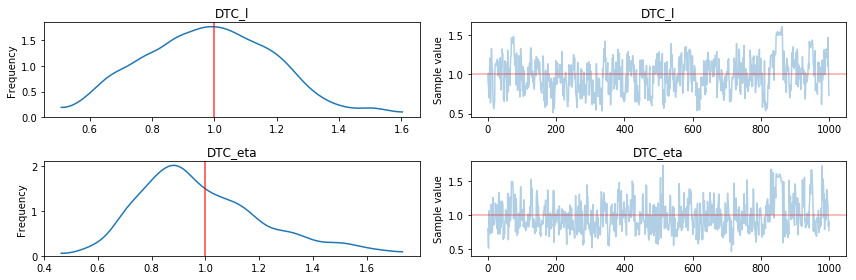

In [105]:
show_traceplot(trace_DTC, model_DTC)

In [124]:
fnew_DTC = model_DTC.predict_f(trace_DTC)

100%|██████████| 1000/1000 [00:06<00:00, 153.53it/s]


/home/ondrej/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


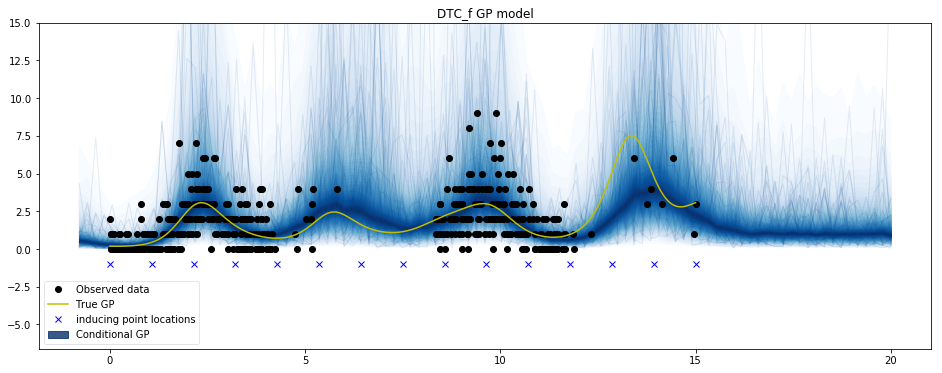

In [151]:
show_ppc(fnew_DTC, model_DTC, Xu=Xu)
#show_ppc(trace_DTC, model_DTC, Xu=Xu, newf=False)
plt.ylim(ymax=15);

In [109]:
with LatentGPModel(approx='FITC', Xu=Xu) as model_FITC:
    trace_FITC = pm.sample(**sample_kw)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [FITC_f_FITC_noise_, FITC_f_u_rotated_, FITC_eta_log__, FITC_l_log__]
100%|██████████| 1500/1500 [07:11<00:00,  3.48it/s]
The acceptance probability does not match the target. It is 0.9843147169181815, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


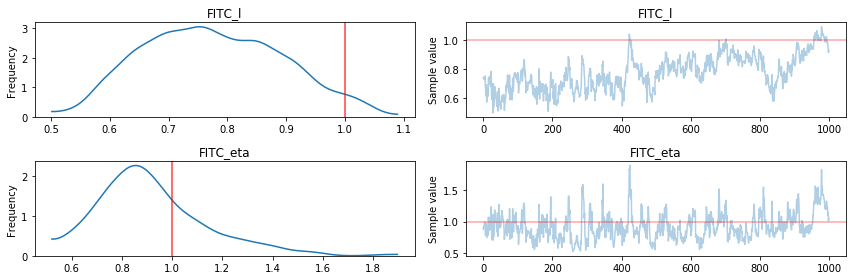

In [110]:
show_traceplot(trace_FITC, model_FITC)

In [111]:
fnew_FITC = model_FITC.predict_f(trace_FITC)

100%|██████████| 1000/1000 [00:08<00:00, 112.75it/s]


/home/ondrej/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


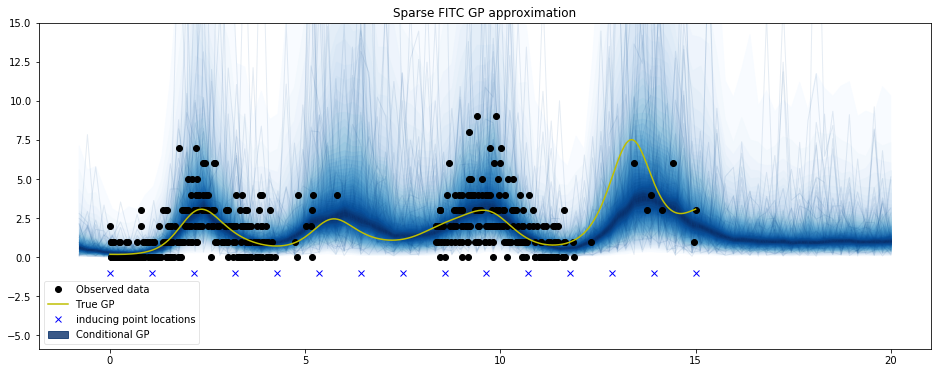

In [113]:
show_ppc(fnew_FITC, model_FITC, Xu=Xu)
plt.ylim(ymax=15)
plt.title('Sparse FITC GP approximation');

In [123]:
comp_df = pm.compare({
    model_full: trace_full, 
    model_DTC: trace_DTC,
    model_FITC: trace_FITC
}, ic='LOO')
comp_df['it/s'] = pm.stats.pd.Series({'FITC': 3.48, 'DTC': 19.43, 'full': 1/1.89})
comp_df

/home/ondrej/projects/pymc3/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn,it/s
FITC,1350.93,33.01,0,0.86,35.98,0,1,3.480000
DTC,1352.17,12.35,1.24,0.14,37.1,2.69,0,19.430000
full,1352.83,12.84,1.9,0,37.09,2.99,0,0.529101


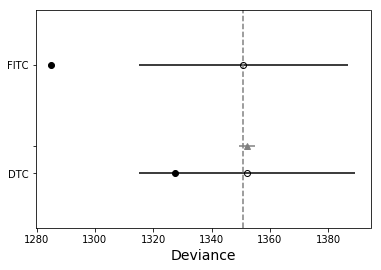

In [115]:
pm.compareplot(comp_df);